In [1]:
import os

os.environ['SNORKELDB'] = "postgresql://localhost:5432/snorkel?user=snorkel&password=snorkel12345"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession

session = SnorkelSession()

In [3]:
from ksnorkel import KSUtils

train_sent, dev_sent, test_sent = KSUtils.split_sentences(session)
print("Amount of sentences: {} train, {} dev and {} test".format(len(train_sent), len(dev_sent), len(test_sent)))

Amount of docs: 9738
Document splitted: 3246 train, 3246 dev and 3246 test
Amount of sentences: 33895 train, 34340 dev and 34326 test


In [4]:
from snorkel.models import Candidate, candidate_subclass
from snorkel.candidates import PretaggedCandidateExtractor


GeneChemicalMetabolism = candidate_subclass('GeneChemicalMetabolism', ['gene', 'chemical'])
candidate_gene_chemical_metabolism_extractor = PretaggedCandidateExtractor(GeneChemicalMetabolism, ['Gene', 'Chemical'])

for k, sents in enumerate([train_sent, dev_sent, test_sent]):
    candidate_gene_chemical_metabolism_extractor.apply(sents, split=k, clear=True)
    print("Number of candidates:", session.query(GeneChemicalMetabolism).filter(GeneChemicalMetabolism.split == k).count())

Clearing existing...


  0%|          | 55/33895 [00:00<01:02, 537.61it/s]

Running UDF...


100%|██████████| 33895/33895 [01:03<00:00, 535.18it/s] 


Number of candidates: 17935
Clearing existing...


  0%|          | 32/34340 [00:00<01:48, 316.60it/s]

Running UDF...


100%|██████████| 34340/34340 [01:12<00:00, 476.61it/s] 


Number of candidates: 16965
Clearing existing...


  0%|          | 32/34326 [00:00<01:48, 316.76it/s]

Running UDF...


100%|██████████| 34326/34326 [01:01<00:00, 554.48it/s] 

Number of candidates: 17138


In [5]:
import gzip

ctd_chem_gene_alternative_interaction = set()
ctd_chem_gene_meta = set()
with gzip.open('data/CTD_chem_gene_ixns.tsv.gz','r') as f:
    for l in f:
        line = str(l).replace('b\'', '').replace('\\n\'', '').replace('\\r','')
        # skip comments
        if line.startswith('#'):
            continue
        #print(line)
        components = line.split('\\t')    
        # add MESH:
        if not components[1].startswith('MESH:'):
            components[1] = "MESH:" + components[1]
            
                
        chemical = components[1]
        gene = components[4]
        key = frozenset((chemical, gene))
                  
        desc = components[8].lower()
        if 'metabol' not in desc:
            ctd_chem_gene_alternative_interaction.add(key)
            continue
            
        descTyp = components[9]
        if 'increases' not in descTyp and 'affects' not in descTyp:
            ctd_chem_gene_alternative_interaction.add(key)
            continue
        
        #che_name = components[0].replace('b\"','').replace('(','\(').replace(')','\)').lower()
        #regex = '{}[^\]\[]+meta'.format(che_name)
        #regex2 = '{}[^\]\[]+decreased activity'.format(che_name)
        #if re.search(regex, desc) == None and re.search(regex2, desc) == None:
            #print(components[0])
            #print(desc)
            #print()
           # continue

        ctd_chem_gene_meta.add(key)

print('{} chemical-gene assocations read from ChG-CTD_chem_gene_ixns'.format(len(ctd_chem_gene_alternative_interaction)))
print('{} chemical-gene metabolisation read from ChG-CTD_chem_gene_ixns'.format(len(ctd_chem_gene_meta)))

def cand_in_chemical_gene_alternative_interaction(c):
    key = frozenset((c.chemical_cid, c.gene_cid))
    if key in ctd_chem_gene_alternative_interaction:
        return 1
    return -1

def cand_in_chemical_gene_metabolised(c):
    key = frozenset((c.chemical_cid, c.gene_cid))
    if key in ctd_chem_gene_meta:
        return 1
    return -1

1042116 chemical-gene assocations read from ChG-CTD_chem_gene_ixns
6085 chemical-gene metabolisation read from ChG-CTD_chem_gene_ixns


In [6]:
from ksnorkel import KSUtils

KSUtils.add_gold_labels_for_candidates(session, GeneChemicalMetabolism, cand_in_chemical_gene_metabolised)

Clearing existing gold labels...
Adding gold labels to training candidates...
Labeld 727 positive and 17208 negative samples in train
Adding gold labels to develop candidates...
Labeld 820 positive and 16145 negative samples in dev
Adding gold labels to test candidates...
Labeld 558 positive and 16580 negative samples in test
Finished - commiting to database...
Commit complete!
Labeld 2105 positive and 49933 negative samples


In [ ]:
def LF_in_CTD_chem_gene(c):
    return cand_in_chemical_gene_interactions(c) 

In [31]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B
)




# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'


metabolisation_samples = ['metabolising', 'metabolism', 'metabolisation', 'metabolization', 
                          'increased activity', 'metabolite', 'stimulation']

def LF_GC_AB_metabolisation_after_AB(c):
    return 1 if (re.search(r'{{A}}.{0,100}' + '{{B}}.{0,100}' + ltp(metabolisation_samples) , get_tagged_text(c), re.I) or
                re.search(r'{{B}}.{0,100}' + '{{A}}.{0,100}' +ltp(metabolisation_samples) , get_tagged_text(c), re.I)) else 0

def LF_GC_metabolisation_before_AB(c):
    return 1 if (rule_regex_search_before_A(c,  ltp(metabolisation_samples) + '.{0,100}', 1) and
                  rule_regex_search_before_B(c, ltp(metabolisation_samples) + '.{0,100}', 1)) else 0



def LF_CG_A_metabolisation_B_far(c):
    return rule_regex_search_btw_AB(c, '.{100,500}' + ltp(metabolisation_samples) + '.{100,500}', -1) 

def LF_GC_B_metabolisation_A_far(c):
    return rule_regex_search_btw_BA(c, '.{100,500}' + ltp(metabolisation_samples) + '.{100,500}', -1)

def LF_GC_A_metabolisation_B(c):
    return rule_regex_search_btw_AB(c, '.{0,100}' + ltp(metabolisation_samples) + '.{0,100}', 1) 

def LF_GC_B_metabolisation_A(c):
    return rule_regex_search_btw_BA(c, '.{0,100}' + ltp(metabolisation_samples) + '.{0,100}', 1)

def LG_GC_metabolisation_before_B_near(c):
    return rule_regex_search_before_B(c, ltp(metabolisation_samples) + '.{0,100}', 1)
 
def LG_GC_metabolisation_before_B_far(c):
    return rule_regex_search_before_B(c, ltp(metabolisation_samples) + '.{100,2000}', -1)




metabol_samples = ['metabol', 'increase', 'stimulate', 'stimulating', 'induce', 'activate', 'potentiate']


def LF_GC_A_metabol_B_in_sent(c):
    return rule_regex_search_btw_AB(c, '.{0,100}' + ltp(metabol_samples) + '.{0,100}', 1) 

def LF_GC_B_metabol_A_in_sent(c):
    return rule_regex_search_btw_AB(c, '.{0,100}' + ltp(metabol_samples) + '.{0,100}', 1) 


def LF_GC_B_metabolised_A(c):
    return rule_regex_search_btw_BA(c, '.{0,100}' + ltp(metabol_samples) + '.{0,100}', 1) 



not_samples = ['no', 'not']

def LF_GC_A_not_metabol_B(c):
    return rule_regex_search_btw_AB(c, '.{0,100}' + ltp(not_samples) + '.{0,100}' + ltp(metabol_samples) + '.{0,100}', -1) 


def LF_GC_B_not_metabolised_A(c):
    return rule_regex_search_btw_BA(c, '.{0,100}' + ltp(not_samples) + '.{0,100}' + ltp(metabol_samples) + '.{0,100}', -1) 


meta_all_words = []
meta_all_words.extend(metabol_samples)
meta_all_words.extend(metabolisation_samples)
     
def LF_GC_no_metabol(c):
    return -1 if not re.search(r'' + ltp(meta_all_words)  , get_tagged_text(c), re.I) else 0

def LF_GC_metabol_in_sent(c):
    return 1 if re.search(r'' + ltp(meta_all_words), get_tagged_text(c), re.I) else 0



inhibition_samples = ["inhibitor", "inhibition", "auto-inhibition", 'inhibitory', 'suppression']


def LF_GC_AB_before_inhibition(c):
    return -1 if (re.search(r'{{A}}.{0,100}' + '{{B}}.{0,100}' + 'inhibition' , get_tagged_text(c), re.I) or
                re.search(r'{{B}}.{0,100}' + '{{A}}.{0,100}' + 'inhibition' , get_tagged_text(c), re.I)) else 0


def LF_GC_A_supressive_effect_B(c):
    return -1 if  re.search(r'{{A}}.{0,100} supressive'+ '.{0,100} effect .{0,100}' + '{{A}}' , get_tagged_text(c), re.I) else 0


def LF_GC_AB_after_inhibition(c):
    return -1 if (rule_regex_search_before_A(c,  ltp(inhibition_samples) + '.{0,100}', 1) and
                  rule_regex_search_before_B(c, ltp(inhibition_samples) + '.{0,100}', 1)) else 0

def LF_GC_A_inhibition_B(c):
    return rule_regex_search_btw_AB(c, '.{0,100}' + ltp(inhibition_samples) + '.{0,100}', -1) 

def LF_GC_B_inhibition_A(c):
    return rule_regex_search_btw_BA(c, '.{0,100}' + ltp(inhibition_samples) + '.{0,100}', -1)

def LG_GC_inhibition_before_B_near(c):
    return rule_regex_search_before_B(c, ltp(inhibition_samples) + '.{0,100}', -1)
 


inhibits_samples = ["inhibit", 'decrease', 'degrees', 'suppress', 'alleviate', 'reduce']

def LF_GC_A_inhibitis_B(c):
    return rule_regex_search_btw_AB(c, '.{0,100}' + ltp(inhibits_samples) + '.{0,100}', -1) 

def LF_GC_A_inhibitis_B_close(c):
    return rule_regex_search_btw_AB(c, '.{0,50}' + ltp(inhibits_samples) + '.{0,50}', -1) 


def LF_GC_inhibits_in_sent(c):
    return -1 if re.search(r'' + ltp(inhibits_samples)  , get_tagged_text(c), re.I) else 0


# prefer meta if both are included
def LF_GC_meta_and_inhibts(c)
    if LF_GC_inhibits_in_sent(c) == -1 and LF_GC_metabol_in_sent(c) == 1:
        return 1
    return 0


def LF_closer_chem(c):
    # Get distance between chemical and gene
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    gen_start, gen_end = c.gene.get_word_start(), c.gene.get_word_end()
    if gen_start < chem_start:
        dist = chem_start - gen_end
    else:
        dist = gen_start - chem_end
    # Try to find chemical closer than @dist/2 in either direction
    sent = c.get_parent()
    closest_other_chem = float('inf')
    for i in range(gen_end, min(len(sent.words), gen_end + dist // 2)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    for i in range(max(0, gen_start - dist // 2), gen_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    return 0


def LF_closer_gene(c):
    # Get distance between chemical and gene
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    gen_start, gen_end = c.gene.get_word_start(), c.gene.get_word_end()
    if gen_start < chem_start:
        dist = chem_start - gen_end
    else:
        dist = gen_start - chem_end
    # Try to find gene closer than @dist/8 in either direction
    sent = c.get_parent()
    for i in range(chem_end, min(len(sent.words), chem_end + dist // 8)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Gene' and cid != sent.entity_cids[gen_start]:
            return -1
    for i in range(max(0, chem_start - dist // 8), chem_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Gene' and cid != sent.entity_cids[gen_start]:
            return -1
    return 0

                

def LF_CG_inhib_between(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.gene.get_word_start(), c.gene.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find metabol closer than @dist/2 in either direction
    sent = c.get_parent()
    closest_other_chem = float('inf')
    for i in range(dis_end, min(len(sent.words), dis_end + dist // 2)):
        if re.search(r'' + ltp(inhibits_samples), sent.words[i], re.I):
            return -1
    for i in range(max(0, dis_start - dist // 2), dis_start):
        if re.search(r'' + ltp(inhibits_samples), sent.words[i], re.I):
            return -1
    return 0


    
LFs_GC = [
    LF_GC_AB_metabolisation_after_AB,
    LF_GC_metabolisation_before_AB,
    LF_CG_A_metabolisation_B_far,
    LF_GC_B_metabolisation_A_far,
    LF_GC_A_metabolisation_B,
    LF_GC_B_metabolisation_A,
    LG_GC_metabolisation_before_B_near,
    LG_GC_metabolisation_before_B_far,
    LF_GC_A_metabol_B_in_sent,
    LF_GC_B_metabol_A_in_sent,
    LF_GC_B_metabolised_A,
    LF_GC_A_not_metabol_B,
    LF_GC_B_not_metabolised_A,
    LF_GC_no_metabol,
    LF_GC_metabol_in_sent,
    LF_GC_AB_before_inhibition,
    LF_GC_A_supressive_effect_B,
    LF_GC_AB_after_inhibition,
    LF_GC_A_inhibition_B,
    LF_GC_B_inhibition_A,
    LG_GC_inhibition_before_B_near,
    LF_GC_A_inhibitis_B,
    LF_GC_A_inhibitis_B_close,
    LF_GC_inhibits_in_sent,
    LF_GC_meta_and_inhibts,
    LF_closer_chem,
    LF_closer_gene,
    LF_CG_inhib_between
]

In [30]:
def LF_CG_in_CTD_chem_gene_metab(c):
    if cand_in_chemical_gene_metabolised(c) == 1:
        return 1 
    return -1

LFs_GC = [
    LF_CG_in_CTD_chem_gene_metab
]

In [32]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs_GC)

%time L_train = labeler.apply(lfs=LFs_GC, parallelism=10)
L_train

  0%|          | 0/17935 [00:00<?, ?it/s]

Clearing existing...
Running UDF...


100%|██████████| 17935/17935 [02:32<00:00, 117.47it/s]


CPU times: user 40.8 s, sys: 9.5 s, total: 50.3 s
Wall time: 2min 33s


<17935x26 sparse matrix of type '<class 'numpy.int64'>'
	with 34981 stored elements in Compressed Sparse Row format>

In [33]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_GC_AB_metabolisation_after_AB,0,0.005966,0.004070,0.003513
LF_GC_metabolisation_before_AB,1,0.000000,0.000000,0.000000
LF_CG_A_metabolisation_B_far,2,0.000000,0.000000,0.000000
LF_GC_B_metabolisation_A_far,3,0.000781,0.000558,0.000000
LF_GC_A_metabolisation_B,4,0.004628,0.003847,0.002398
LF_GC_B_metabolisation_A,5,0.005687,0.005018,0.002676
LG_GC_metabolisation_before_B_near,6,0.006022,0.004628,0.004461
LG_GC_metabolisation_before_B_far,7,0.001951,0.001728,0.000558
LF_GC_A_metabol_B_in_sent,8,0.031057,0.031057,0.016114
LF_GC_B_metabol_A_in_sent,9,0.031057,0.031057,0.016114


In [10]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_GC_AB_metabolisation_after_AB,0,0.000781,0.000558,0.000502
LF_GC_metabolisation_before_AB,1,0.000000,0.000000,0.000000
LF_CG_A_metabolisation_B_far,2,0.000000,0.000000,0.000000
LF_GC_B_metabolisation_A_far,3,0.000558,0.000335,0.000000
LF_GC_A_metabolisation_B,4,0.000781,0.000781,0.000446
LF_GC_B_metabolisation_A,5,0.001059,0.001004,0.000781
LG_GC_metabolisation_before_B_near,6,0.001227,0.001115,0.001115
LG_GC_metabolisation_before_B_far,7,0.000390,0.000279,0.000000
LF_GC_A_metabol_B_in_sent,8,0.021801,0.021801,0.011151
LF_GC_B_metabol_A_in_sent,9,0.021801,0.021801,0.011151


In [34]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)
train_marginals = gen_model.marginals(L_train)

Inferred cardinality: 2


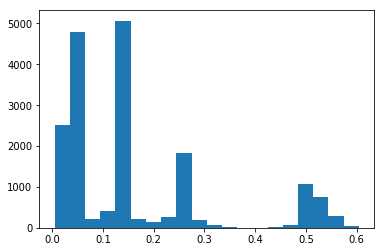

In [35]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [36]:
from snorkel.annotations import load_gold_labels

L_dev = labeler.apply_existing(split=1)
L_test = labeler.apply_existing(split=2)
L_gold_dev = load_gold_labels(session, annotator_name='gold',split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

  0%|          | 2/16965 [00:00<14:52, 19.00it/s]

Clearing existing...
Running UDF...


  0%|          | 6/17138 [00:00<04:54, 58.14it/s]

Clearing existing...
Running UDF...


100%|██████████| 17138/17138 [03:34<00:00, 79.76it/s]


In [ ]:
from snorkel.learning import GenerativeModel
from snorkel.learning import RandomSearch
from snorkel.learning.structure import DependencySelector


MAX_DEPS = 5

ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
deps = set(list(deps)[0:min(len(deps), MAX_DEPS)])

print("Using {} dependencies".format(len(deps)))



# use random search to optimize the generative model
param_grid = {
    'step_size' : [1e-3, 1e-4, 1e-5, 1e-6],
    'decay'     : [0.9, 0.95],
    'epochs'    : [50,100,150],
    'reg_param' : [1e-3],
}

model_class_params = {'lf_propensity' : False }#, 'deps': deps}

searcher = RandomSearch(GenerativeModel, param_grid, L_train, n=10, model_class_params=model_class_params)
%time gen_model, run_stats = searcher.fit(L_dev, L_gold_dev) #, deps=deps)
run_stats

In [37]:
train_marginals = gen_model.marginals(L_train)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [14]:
from snorkel.annotations import save_marginals

dev_marginals = gen_model.marginals(L_dev)
_, _, _, _ = gen_model.error_analysis(session, L_dev, L_gold_dev)

%time save_marginals(session, L_train, train_marginals)

Scores (Un-adjusted)
Pos. class accuracy: 0.0549
Neg. class accuracy: 0.968
Precision            0.0809
Recall               0.0549
F1                   0.0654
----------------------------------------
TP: 45 | FP: 511 | TN: 15634 | FN: 775

Saved 17935 marginals
CPU times: user 12.3 s, sys: 740 ms, total: 13 s
Wall time: 17.8 s


In [15]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.0323
Neg. class accuracy: 0.97
Precision            0.0354
Recall               0.0323
F1                   0.0338
----------------------------------------
TP: 18 | FP: 490 | TN: 16090 | FN: 540



In [16]:
print("Load all ChemicalGeneMetabolism candidates from db...")
train_cands = session.query(GeneChemicalMetabolism).filter(GeneChemicalMetabolism.split == 0).order_by(GeneChemicalMetabolism.id).all()
dev_cands   = session.query(GeneChemicalMetabolism).filter(GeneChemicalMetabolism.split == 1).order_by(GeneChemicalMetabolism.id).all()
test_cands  = session.query(GeneChemicalMetabolism).filter(GeneChemicalMetabolism.split == 2).order_by(GeneChemicalMetabolism.id).all()


all_cands = []
all_cands.extend(train_cands)
all_cands.extend(dev_cands)
all_cands.extend(test_cands)


print("{} {} {}".format(len(train_cands), len(dev_cands), len(test_cands)))
print("Amount of all candidates: {}".format(len(all_cands)))

Load all ChemicalGeneMetabolism candidates from db...
17935 16965 17138
Amount of all candidates: 52038


In [38]:
from snorkel.learning.pytorch import LSTM
from snorkel.annotations import load_gold_labels
import torch
import torch.nn as nn

#train_kwargs = #{
#    'lr':            0.01,#
#    'embedding_dim': 75,
#    'hidden_dim':    75,
#    'n_epochs':      1,
#    'dropout':       0.25,
#    'seed':          1701
#}

train_kwargs = {
    'batch_size':    128,
    'lr':            0.0010,
    'embedding_dim': 75,
    'hidden_dim':    75,
    'n_epochs':      10,
    'dropout':       0.25,
    'rebalance':     0.0,
    'seed':          1701
}


lstm = LSTM(n_threads=10)
#lstm.loss = torch.nn.KLDivLoss()

In [39]:

lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[LSTM] Training model
[LSTM] n_train=16863  #epochs=10  batch size=128
[LSTM] Epoch 1 (148.58s)	Average loss=0.441025	Dev F1=0.00
[LSTM] Epoch 2 (322.86s)	Average loss=0.402943	Dev F1=0.24
[LSTM] Epoch 3 (501.09s)	Average loss=0.385076	Dev F1=0.24
[LSTM] Epoch 4 (685.89s)	Average loss=0.375988	Dev F1=0.23
[LSTM] Epoch 5 (861.34s)	Average loss=0.371616	Dev F1=1.47
[LSTM] Epoch 6 (1036.25s)	Average loss=0.368820	Dev F1=1.29
[LSTM] Epoch 7 (1208.72s)	Average loss=0.366908	Dev F1=2.30
[LSTM] Epoch 8 (1388.94s)	Average loss=0.365985	Dev F1=1.48
[LSTM] Epoch 9 (1569.75s)	Average loss=0.364969	Dev F1=1.30
[LSTM] Model saved as <LSTM>
[LSTM] Epoch 10 (1749.09s)	Average loss=0.364562	Dev F1=1.98
[LSTM] Model saved as <LSTM>
[LSTM] Training done (1798.54s)
[LSTM] Loaded model <LSTM>


In [40]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.00717
Neg. class accuracy: 0.992
Precision            0.0288
Recall               0.00717
F1                   0.0115
----------------------------------------
TP: 4 | FP: 135 | TN: 16445 | FN: 554



In [41]:
p, r, f1 = lstm.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.029, Recall: 0.007, F1 Score: 0.011


In [42]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.00717
Neg. class accuracy: 0.992
Precision            0.0288
Recall               0.00717
F1                   0.0115
----------------------------------------
TP: 4 | FP: 135 | TN: 16445 | FN: 554



In [43]:
lstm.save_marginals(session, all_cands)

Saved 52038 marginals


In [44]:
from snorkel.models.candidate import Marginal
from snorkel.models import Document, Sentence


print("Storing candidate labels into result file...")
amount_of_candidates = session.query(Candidate).count()
print("Amount of candidates: {}".format(amount_of_candidates))

all_sents = []
all_sents.extend(train_sent)
all_sents.extend(dev_sent)
all_sents.extend(test_sent)


Storing candidate labels into result file...
Amount of candidates: 52038


In [45]:
header_str = '{}\t{}\t{}\t{}\t{}\t{}\t{}'.format('sentence_id', 'cand_id','gene_cid', 'gene_span', 'chemical_cid', 'chemical_span', 'sentence')
%time KSUtils.save_binary_relation_confusion_matrix_as_tsv('results/gene_chemical_metabolisation.tsv', session, all_cands, all_sents, header_str, 'gene_cid', 'chemical_cid')

Storing candidate labels into result file: results/gene_chemical_metabolisation.tsv
Amount of candidates: 52038
Load mariginals from db...
Marginals loaded!
Load gold labels from db...
Gold labels loaded!
Start writing files...
Saved 53 TP, 1186 FP, 48747 TN, 2052 FN facts in files.
CPU times: user 1min 52s, sys: 4.82 s, total: 1min 57s
Wall time: 2min 18s


In [ ]:
header_str = '{}\t{}\t{}\t{}\t{}\t{}\t{}'.format('document_id', 'sentence_id', 'cand_id','gene_cid', 'gene_span', 'chemical_cid', 'chemical_span')
%time KSUtils.save_binary_relation_as_tsv('results/chemical_gene_metabolisation.tsv', session, all_cands, all_sents, header_str, 'gene_cid', 'chemical_cid')

In [46]:
lstm.save("gene_chemical_metabolism.lstm")

[LSTM] Model saved as <gene_chemical_metabolism.lstm>
